<a href="https://colab.research.google.com/github/EJLEE5826/cau_deep_learning_2025/blob/main/6%EC%A3%BC%EC%B0%A8_Multi_layer_Perceptron_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Multi-layer Perceptron (MLP)

MLP는 기존의 선형 분류기(Linear Classifier)를 확장한 개념입니다.

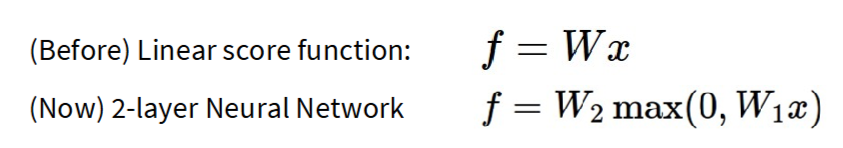


입력층(Input Layer)과 출력층(Output Layer) 사이에 은닉층(Hidden Layer)을 추가한 구조로,
각 층은 가중치 행렬(W1, W2)과 비선형 활성화 함수(non-linearity function, 예시: max(0, •))로 구성됩니다.

이러한 구조를 완전 연결 신경망(Fully-connected Network)이라고도 부릅니다.


## Non-linearity function 사용 이유

만약 비선형 활성화 함수가 없다면, 결국 하나의 선형 변환과 같아져, 여러 층을 쌓는 의미가 사라집니다.
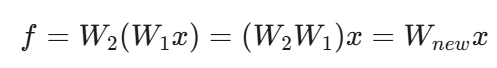



선형 분류기로는 나눌 수 없는 데이터를 분류하기 위해, 활성화 함수가 데이터를 비선형 공간으로 변환시켜주는 역할을 합니다.

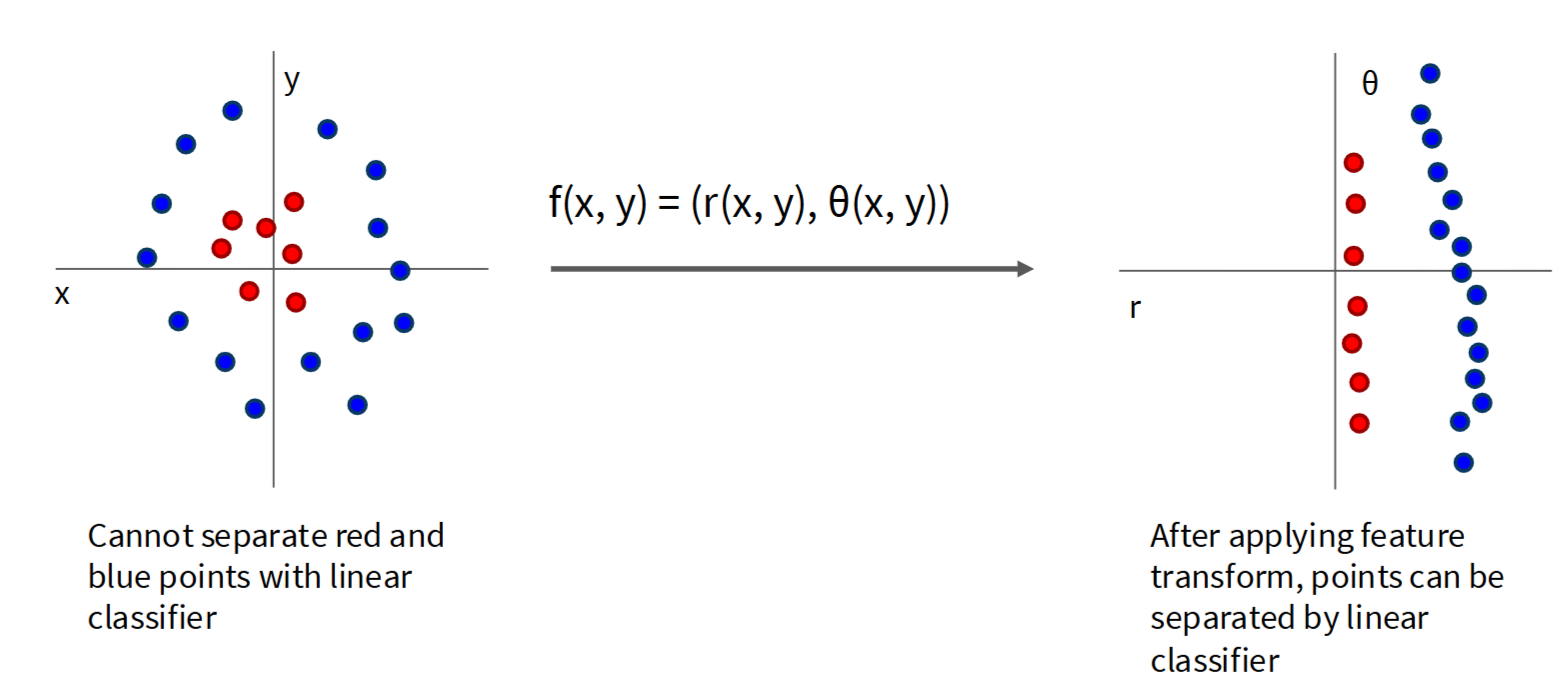

# Multi-layer Perceptron & Backpropagtion (Numpy)

## 2-layer MLP

### Imports and Plotting Functions

In [ ]:
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay

np.random.seed(231) # 재현성을 위해 seed 고정
np.set_printoptions(precision=4) # numpy 배열 출력 시 소수점 넷째 자리까지 표시하도록 설정

In [ ]:
def plot_decision_boundary(
    estimator, # 결정 경계를 그릴 모델 (여기서는 MLPClassifier)
    X, # 데이터 포인트 (입력 특성)
    *,
    grid_resolution=100, # 결정 경계를 계산할 격자의 해상도
    eps=1.0, # 결정 경계를 그릴 때 데이터 범위의 확장 정도
    **kwargs,
):
    """
    주어진 분류 모델의 prediction thresholds에 대한 contour plot을 생성하여 결정 경계 시각화
    : 모델이 다른 클래스를 어떻게 구분하는지 확인 가능
    """

    # 입력 데이터 X에서 첫 번째(x0)와 두 번째(x1) 특성을 분리
    x0, x1 = X[:,0],X[:,1]

    # 결정 경계를 그릴 격자의 범위를 설정. 데이터의 최소/최대 값에서 eps만큼 확장
    x0_min, x0_max = x0.min() - eps, x0.max() + eps
    x1_min, x1_max = x1.min() - eps, x1.max() + eps

    # 설정된 범위 내에서 grid_resolution 해상도로 그리드 포인트 생성
    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, grid_resolution),
        np.linspace(x1_min, x1_max, grid_resolution),
    )

    # 그리드 포인트를 모델 입력 형식에 맞게 reshape
    X_grid = np.c_[xx0.ravel(), xx1.ravel()]

    # 그리드 포인트에 대해 모델의 forward pass를 실행하여 예측 값 얻음
    response = estimator.forward(X_grid)

    # DecisionBoundaryDisplay 객체 생성 (결정 경계 표시할 준비)
    display = DecisionBoundaryDisplay(
        xx0=xx0, # 그리드 x0 좌표
        xx1=xx1, # 그리드 x1 좌표
        response=response.reshape(xx0.shape), # 그리드에 대한 모델의 예측 값
    )
    # contourf (채워진 등고선) 플롯을 사용하여 결정 경계 그림
    display.plot(plot_method="contourf", **kwargs)

    # 생성된 display 객체 반환
    return display

In [ ]:
def visualize_dataset(x, y, title="Dataset visualization"):
    """
    주어진 데이터의 scatter plot을 생성하여 시각화합니다.
    각 데이터 포인트는 라벨에 따라 색상이 구분됩니다.
    """
    # x의 첫 번째 열과 두 번째 열을 x, y 좌표로 사용하여 산점도 생성.
    scatter = plt.scatter(*x.T, c=y) # c=y로 라벨에 따라 색상 지정

    plt.title(title) # 시각화 제목 설정
    plt.legend(handles=scatter.legend_elements()[0], labels=[0,1])
    plt.grid(visible=True, which='both')
    plt.figure(figsize=(6, 6))
    plt.show()

def visualize_weights(mlp, gradients=True):
    """
    MLPClassifier의 첫 번째 layer weights와 gradients를 시각화합니다.
    weights는 원점 (0,0)에서 시작하는 벡터로 표시됩니다.
    gradients가 True이면 현재 weights 위치에서 gradient 방향으로의 벡터도 표시됩니다.
    """
    # 가중치 행렬 mlp.w1과 같은 형태의 영 행렬을 생성합니다. 화살표의 시작점으로 사용됩니다.
    z = np.zeros(mlp.w1.shape)

    # 첫 번째 layer의 가중치 벡터 (mlp.w1의 각 열)를 화살표로 그립니다.
    # z[0, :]와 z[1, :]는 화살표의 시작점 (0,0)을, mlp.w1[0, :]와 mlp.w1[1, :]는 화살표의 끝점을 정의합니다.
    plt.quiver(z[0, :], z[1, :], mlp.w1[0, :], mlp.w1[1, :],
               scale=1, width=0.005, angles='xy', scale_units='xy') # scale=1, scale_units='xy'는 데이터 단위로 스케일링함을 의미

    # gradients가 True이면 gradient 벡터를 빨간색 화살표로 그립니다.
    if gradients:
        # gradient 벡터는 현재 weights 위치에서 시작합니다.
        # -mlp.lr * mlp.grad_w1은 gradient descent 방향으로의 업데이트 벡터를 나타냅니다.
        plt.quiver(mlp.w1[0, :], mlp.w1[1, :],
                   -mlp.lr * mlp.grad_w1[0, :],
                   -mlp.lr * mlp.grad_w1[1, :],
                   scale=1, width=0.01, angles='xy', scale_units='xy', color='r')
    plt.grid(visible=True, which='both')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.show()

### Generate Example Dataset

In [ ]:
# make_circles 함수를 사용하여 예제 데이터셋을 생성합니다.
X, y = datasets.make_circles(n_samples=1000, noise=0.05, factor=0.5)    # n_samples: 데이터 포인트 수
                                                                        # noise: 데이터에 추가할 노이즈의 표준 편차
                                                                        # factor: 내부 원과 외부 원 사이의 비율 (반지름)

# 레이블 y의 차원을 (1000,)에서 (1000, 1)로 변경하여 열 벡터 형태로 만듭니다.
# (MLP 출력 차원과 일치시키기 위해)
y = y[:, np.newaxis]

# 생성된 데이터와 레이블의 차원을 출력합니다.
print(f"데이터의 차원은 {X.shape}이고 labels의 차원은 {y.shape}입니다.")

데이터의 차원은 (1000, 2)이고 labels의 차원은 (1000, 1)입니다.


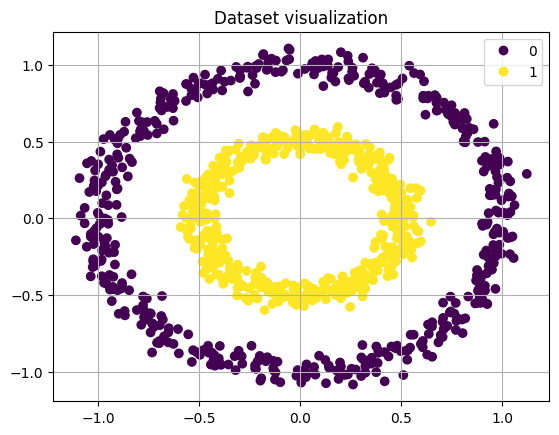

<Figure size 600x600 with 0 Axes>

In [ ]:
visualize_dataset(X, y)

### Define Activation functions and Classifier

**Sigmoid**

Sigmoid는 초창기 신경망에서 널리 사용되었던 대표적인 비선형 활성화 함수입니다.

특징:

- 어떤 입력값이든 0과 1 사이의 값으로 변환해 줍니다.  이 특성 때문에 확률을 모델링하는 데 유용합니다.

- 그래프 모양이 S자 형태로, 생물학적 뉴런의 '발화율(firing rate)'을 모사하는 데 사용되었습니다.

- 입력값이 너무 크거나 작으면 그래프가 평평해져 기울기가 0에 가까워지는 기울기 소실(Vanishing Gradient) 문제가 발생할 수 있습니다. 이는 깊은 신경망의 학습을 방해하는 요인이 됩니다.


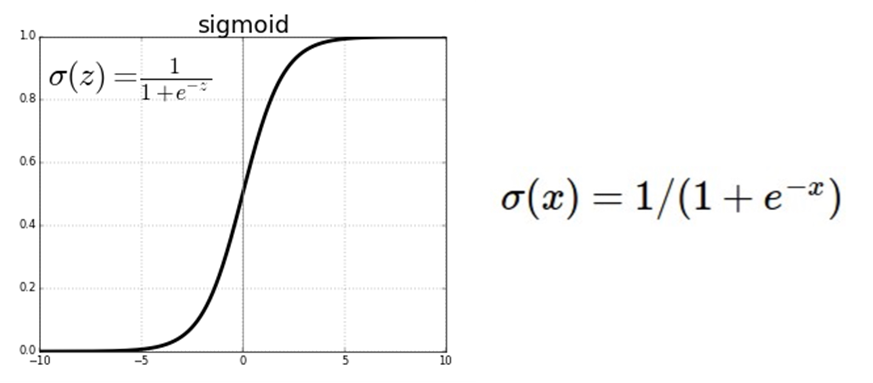

**ReLU**

ReLU는 가장 널리 사용되는 기본 활성화 함수 중 하나입니다.

입력값이 0보다 크면 값을 그대로 출력하고, 0보다 작으면 0을 출력합니다.

특징:
- 계산이 매우 빠릅니다.
- 특정 조건에서 발생할 수 있는 Gradient Vanishing 문제를 완화합니다.
- 구현이 간단합니다.

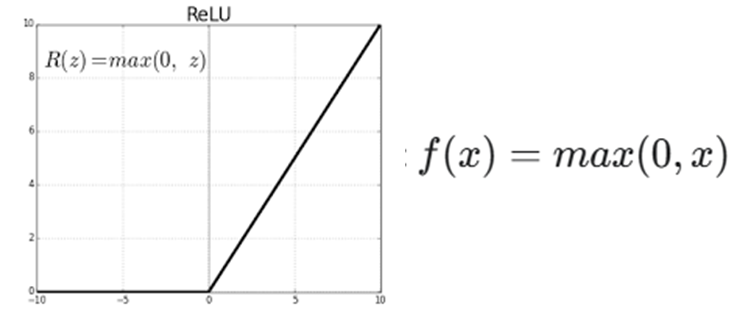

In [ ]:
def relu(x):
    """
    Rectified Linear Unit (ReLU) 활성화 함수를 정의합니다.
    입력이 0보다 크면 입력을 그대로 반환하고, 0보다 작거나 같으면 0을 반환합니다.
    """
    return np.maximum(x, 0)

def sigmoid(x):
    """
    Sigmoid 활성화 함수를 정의합니다.
    입력 값을 0에서 1 사이의 값으로 스케일링합니다.
    주로 이진 분류 모델의 마지막 레이어에서 확률을 출력할 때 사용됩니다.
    """
    return 1 / (1 + np.exp(-x))

def cross_entropy(preds, labels):
    """
    Binary cross entropy loss 함수를 계산합니다.
    이진 분류 문제에서 모델의 예측 값(확률)과 실제 레이블 간의 차이를 측정하는 데 사용됩니다.

    Args:
        preds:  모델이 예측한 클래스 1에 속할 확률 (predicted probabilities)
        labels: 실제 레이블 (ground truth labels), 0 또는 1 값
    """
    # 아주 작은 값(예: 1e-15)을 더하여 log(0)이 되는 것을 방지합니다.
    preds = np.clip(preds, 1e-15, 1 - 1e-15)
    # 이진 교차 엔트로피 손실을 계산합니다.
    # - (y * log(y_pred) + (1 - y) * log(1 - y_pred))의 평균
    return -np.mean(labels * np.log(preds) + (1 - labels) * np.log(1 - preds))

**Feed-Forward Computation**

피드포워드(Feed-forward)는 입력 데이터가 신경망의 입력층에서 출력층까지 순서대로 통과하며 예측값을 계산하는 과정입니다.
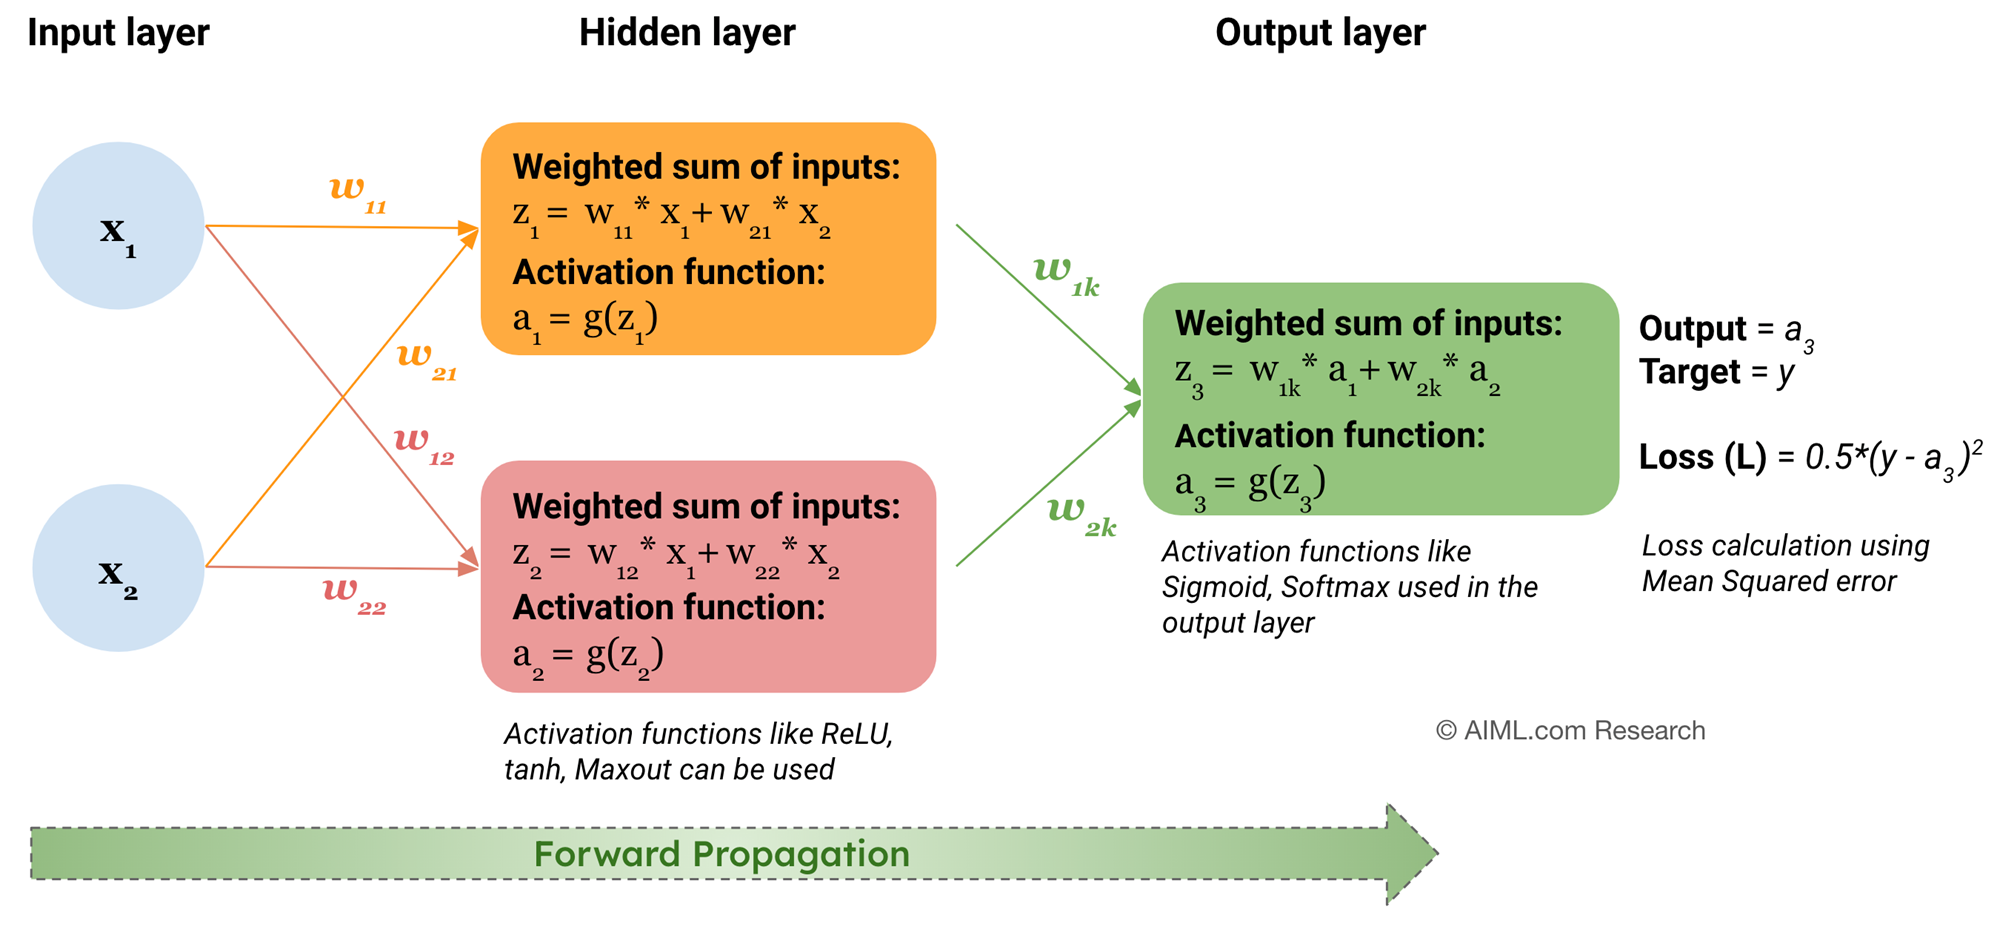

**Backpropagation**

손실을 줄이기 위해 각 가중치(W)가 손실에 얼마나 영향을 미치는지 알아야 합니다. 이 "영향도"가 바로 기울기(Gradient) 입니다.


역전파(Backpropagation)는 계산 그래프(Computational Graph)와 연쇄 법칙(Chain Rule)을 이용하여 이 기울기를 효율적으로 계산하는 알고리즘입니다.

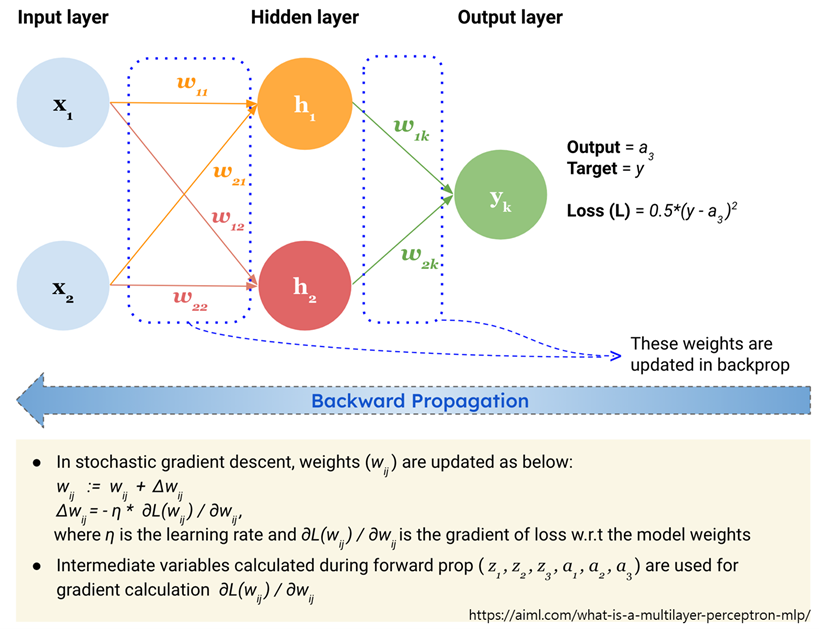

In [ ]:
class MLPClassifier():
    def __init__(self, lr=1e-2, in_dim=2, out_dim=1, h_dim=3):
        """
        간단한 2-layer (input, hidden, output) multilayer perceptron (MLP) 분류기를 초기화합니다.

        Args:
            lr:      학습률 (learning rate). 가중치 업데이트 시 사용됩니다.
            in_dim:  입력 데이터의 차원 (input dimension). 여기서는 2D 데이터이므로 2입니다.
            out_dim: 출력 레이어의 차원 (output dimension). 이진 분류이므로 1입니다.
            h_dim:   은닉 레이어의 차원 (hidden dimension). 은닉 뉴런의 수를 결정합니다.
        """
        # 학습률을 저장합니다.
        self.lr = lr

        # 첫 번째 레이어 (input -> hidden)의 가중치 행렬 w1을 초기화합니다.
        # He 초기화 방법을 사용하여 ReLU 활성화 함수에 적합하게 초기화합니다.
        self.w1 = np.random.randn(in_dim, h_dim) * np.sqrt(2 / in_dim) # shape: (in_dim, h_dim)

        # 두 번째 레이어 (hidden -> output)의 가중치 행렬 w2를 초기화합니다.
        self.w2 = np.random.randn(h_dim, out_dim) * np.sqrt(2 / h_dim) # shape: (h_dim, out_dim)

        # 출력 레이어의 bias 벡터 b를 초기화합니다.
        # 작은 양의 값으로 초기화하여 시그모이드 출력이 0에 가깝지 않도록 합니다.
        self.b = np.zeros(out_dim) + 0.1 # shape: (out_dim,)

    def forward(self, x):
        """
        MLP의 순방향 전달 (forward pass)을 수행합니다.
        입력 데이터를 받아 은닉 레이어를 거쳐 최종 출력(예측 확률)을 계산합니다.

        Args:
            x: 입력 데이터 (input data)로, 형태는 (dataset_size, in_dim) 입니다.

        Returns:
            y_pred: 클래스 1에 속할 predicted probabilities로, 형태는 (dataset_size, out_dim) 입니다.
        """
        # gradient 계산을 위해 입력 데이터를 클래스 변수에 저장합니다.
        self.x = x

        # 첫 번째 레이어의 선형 변환 및 ReLU 활성화 함수를 적용합니다.
        # h = relu(x @ w1)
        # gradient 계산을 위해 relu output을 클래스 변수에 저장합니다.
        self.h = relu(self.x @ self.w1)

        # 두 번째 레이어의 선형 변환 및 bias를 더합니다.
        # z = h @ w2 + b
        # viewing purposes를 위해 z 값을 저장합니다. (backwards에서는 직접 사용되지 않음)
        self.z = self.h @ self.w2 + self.b

        # 최종 출력 레이어에 sigmoid 활성화 함수를 적용하여 예측 확률을 얻습니다.
        y_pred = sigmoid(self.z)

        # 예측 확률을 반환합니다.
        return y_pred


    def backward(self, y_pred, grad_y_pred):
        """
        MLP의 역방향 전달 (backwards pass)을 수행합니다.
        손실의 gradient를 사용하여 각 가중치 및 bias에 대한 gradient를 계산합니다.

        Args:
            y_pred:      forward pass에서 계산된 클래스 1에 속할 predicted probabilities (예측 확률)
            grad_y_pred: y_pred에 대한 loss의 gradient. 손실 함수로부터 계산됩니다.
        """
        # 출력 레이어의 gradient를 계산합니다. (시그모이드 함수의 미분 (y_pred * (1 - y_pred))을 곱함)
        grad_z = y_pred * (1-y_pred) * grad_y_pred

        # w2에 대한 gradient를 계산합니다. (grad_z와 은닉 레이어 출력 h의 행렬 곱)
        self.grad_w2 = self.h.T @ grad_z # shape: (h_dim, out_dim)

        # b에 대한 gradient를 계산합니다. (grad_z의 합)
        self.grad_b  = np.sum(grad_z, axis=0) # batch에 대한 합계, # shape: (out_dim,)

        # 은닉 레이어의 gradient를 계산합니다. (grad_z와 w2의 전치 행렬 곱)
        self.grad_h  = grad_z @ self.w2.T # shape: (dataset_size, h_dim)

        # w1에 대한 gradient를 계산합니다.
        # ( 은닉 레이어의 gradient에 ReLU 함수의 미분 (h > 0)을 곱한 뒤 입력 x와 행렬 곱)
        self.grad_w1 = self.x.T @ ((self.h > 0) * self.grad_h) # shape: (in_dim, h_dim)

    def update(self):
        """
        계산된 gradients를 사용하여 SGD 방식으로 weights와 bias를 업데이트합니다.
        업데이트는 learning rate에 의해 조절됩니다.
        """
        # w1 가중치를 gradient 방향의 반대로 learning rate만큼 이동하여 업데이트합니다.
        self.w1 -= self.lr * self.grad_w1

        # w2 가중치를 업데이트합니다.
        self.w2 -= self.lr * self.grad_w2

        # bias b를 업데이트합니다.
        self.b  -= self.lr * self.grad_b

### Train MLPClassifier

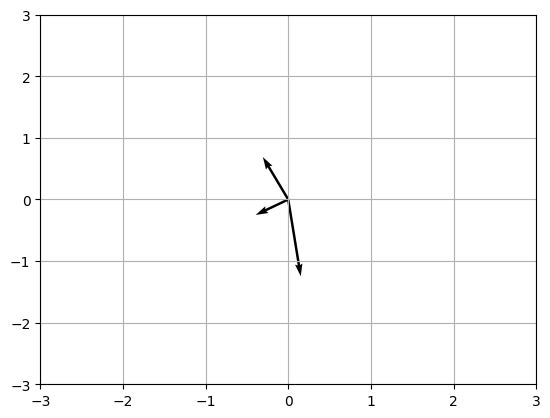

In [ ]:
# MLPClassifier 모델을 초기화합니다.
# learning rate=5e-3, hidden layer dimension=3으로 설정합니다.
mlp = MLPClassifier(lr=5e-3, h_dim=3)

# 손실 기록을 저장할 리스트를 초기화하고, 초기 손실 값을 무한대로 설정합니다.
loss_history, loss = [np.inf], np.inf

# 훈련 시작 전 MLP의 첫 번째 layer weights를 시각화합니다. (gradients는 표시하지 않음)
visualize_weights(mlp, gradients=False)

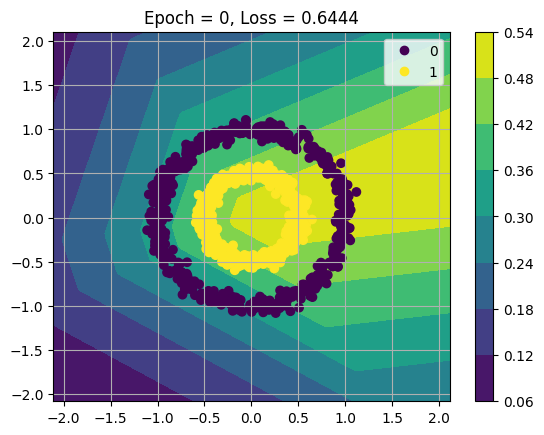

<Figure size 600x600 with 0 Axes>

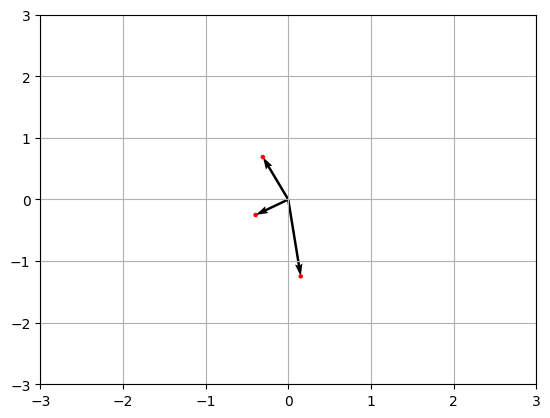

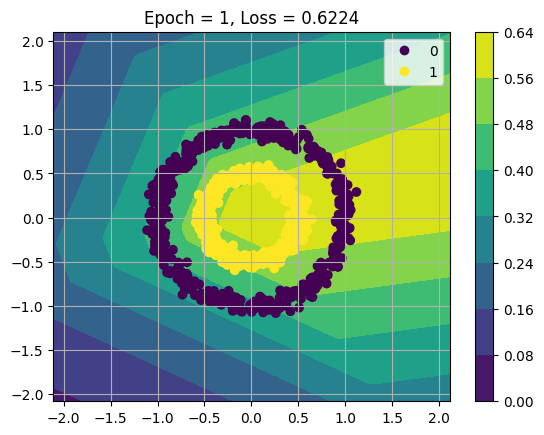

<Figure size 600x600 with 0 Axes>

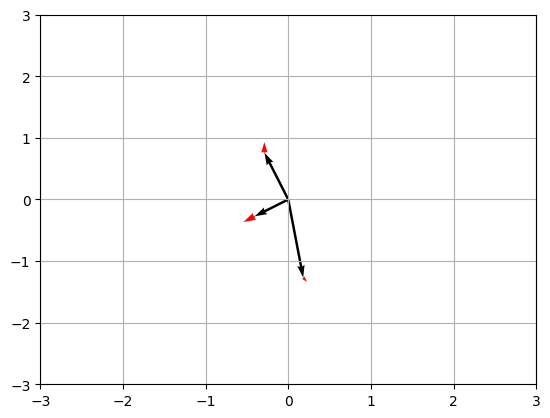

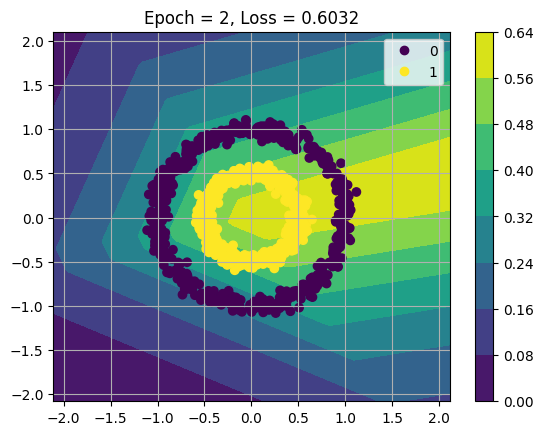

<Figure size 600x600 with 0 Axes>

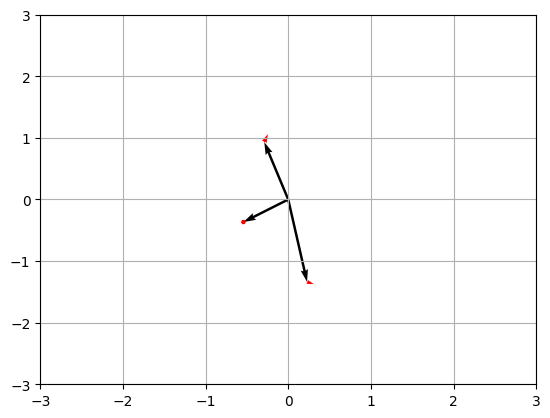

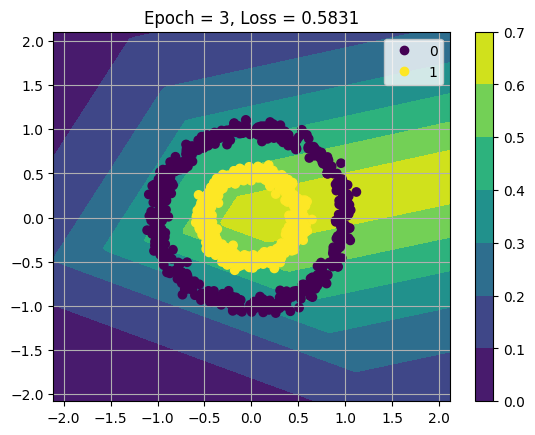

<Figure size 600x600 with 0 Axes>

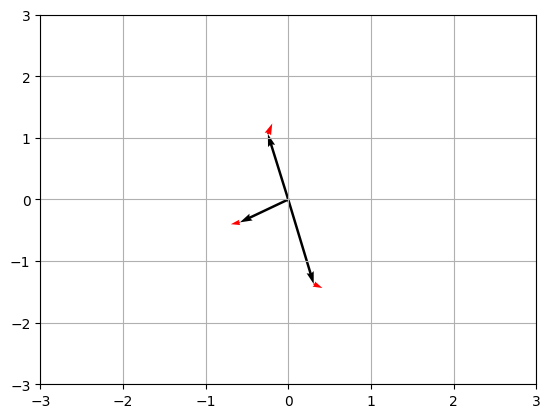

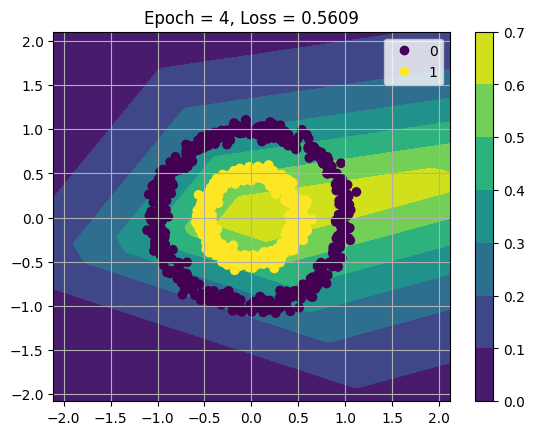

<Figure size 600x600 with 0 Axes>

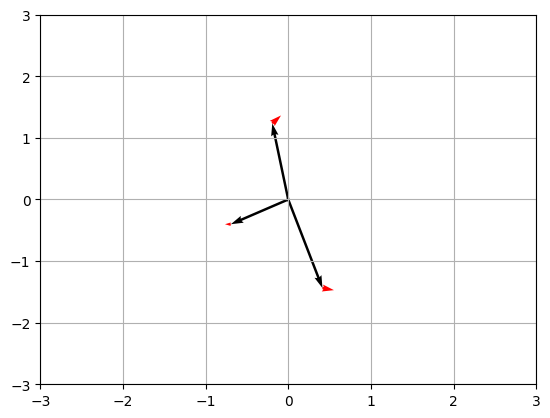

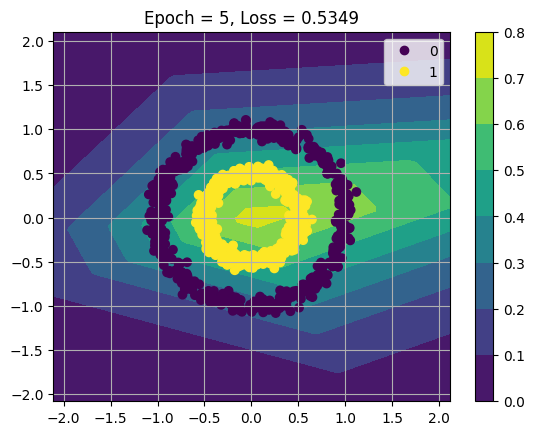

<Figure size 600x600 with 0 Axes>

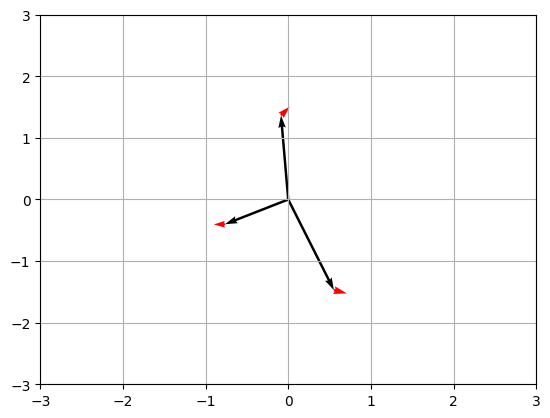

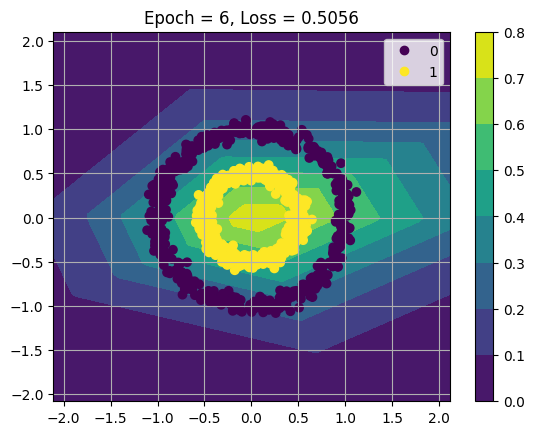

<Figure size 600x600 with 0 Axes>

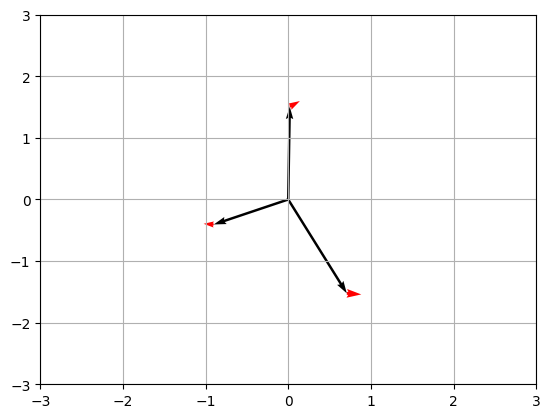

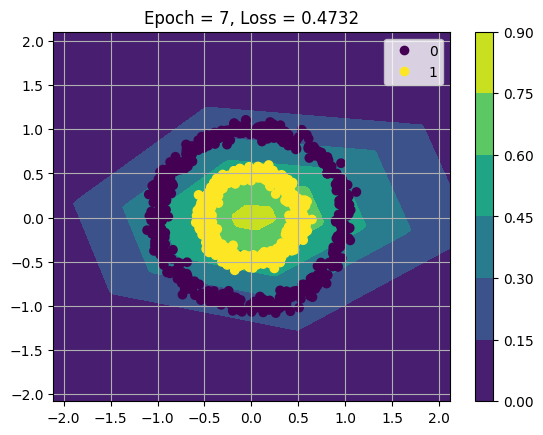

<Figure size 600x600 with 0 Axes>

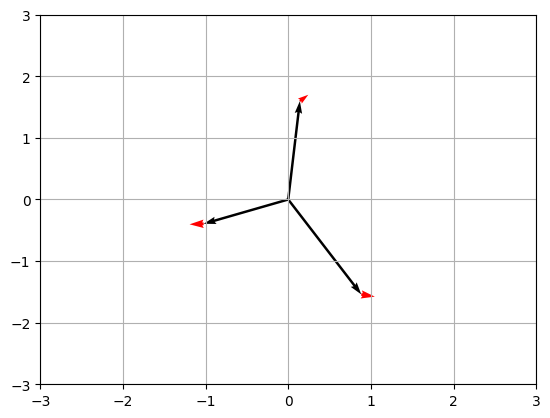

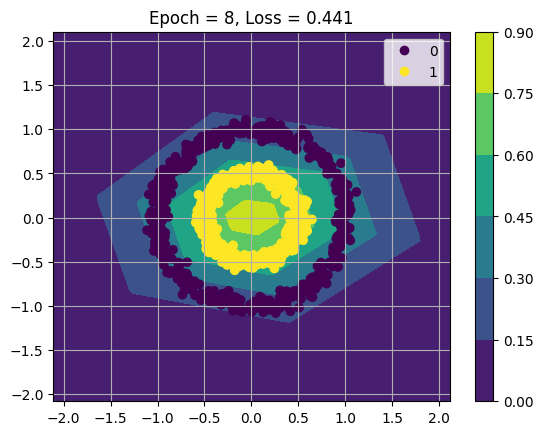

<Figure size 600x600 with 0 Axes>

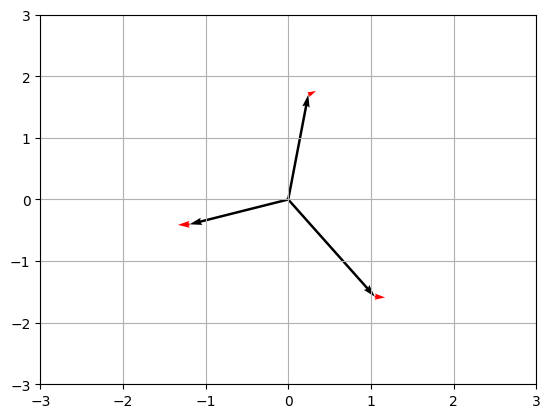

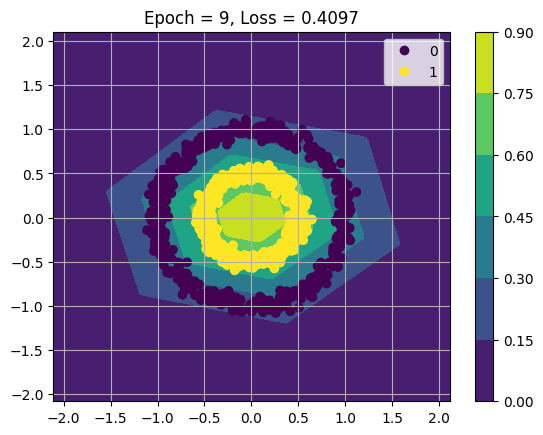

<Figure size 600x600 with 0 Axes>

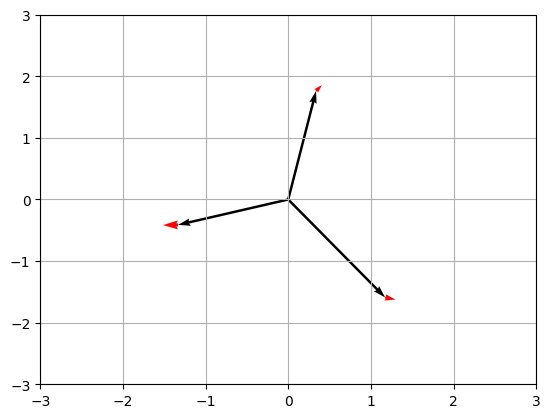

In [ ]:
# 훈련할 epoch 수를 설정합니다.
epochs = 10 # 0부터 9까지 총 10 epoch

# 설정된 epoch 수만큼 훈련을 반복합니다.
for t in range(epochs):

    # 현재 epoch에서 데이터에 대한 예측을 수행합니다 (forward pass).
    y_pred = mlp.forward(X)

    # 예측 값과 실제 레이블을 사용하여 cross entropy loss를 계산하고 저장합니다.
    loss = cross_entropy(y_pred, y)
    loss_history.append(loss)

    # loss gradient를 계산하고 errors를 역전파합니다 (backwards pass)
    # loss에 대한 y_pred의 gradient를 계산합니다. (binary cross entropy loss의 미분)
    grad_y_pred = -(np.divide(y, y_pred) - np.divide(1-y, 1-y_pred))

    # 계산된 grad_y_pred를 사용하여 MLP 모델의 backward 메소드를 호출하여 각 layer의 gradient를 계산합니다.
    mlp.backward(y_pred, grad_y_pred)

    # 일정 epoch 간격 (epochs // 10)으로 classifier의 결정 경계와 weights를 시각화합니다.
    if t % (epochs // 10) == 0:
        # 현재 모델의 결정 경계를 시각화합니다.
        display = plot_decision_boundary(mlp, X)

        plt.colorbar(display.ax_.collections[0]) # 결정 경계 플롯에 예측 확률 값을 함께 표시
        visualize_dataset(X, y, title=f"Epoch = {t}, Loss = {round(loss, 4)}") # 데이터셋 시각화
        visualize_weights(mlp) # 현재 MLP의 첫 번째 layer weights와 gradients를 시각화

    # 계산된 gradients를 사용하여 모델의 weights와 bias를 업데이트합니다.
    mlp.update()

In [ ]:
# 예측 값을 이진 클래스 (0 또는 1)로 변환하기 위한 threshold를 설정합니다.
threshold = 0.5

# 모델의 최종 accuracy를 계산합니다.
# (y_pred > threshold)는 예측 확률이 0.5보다 크면 True, 아니면 False인 boolean 배열입니다.
# 이 boolean 배열과 실제 레이블 y를 비교하여 예측이 맞았는지 확인합니다.
# np.sum(...)은 맞은 예측의 총 수를 계산합니다.
# X.shape[0]는 데이터셋의 총 샘플 수입니다.
# 정확도 = (맞은 예측 수) / (총 샘플 수)
acc = np.sum((y_pred > threshold) == y) / X.shape[0]

# 계산된 accuracy를 출력합니다.
print(f"Accuracy = {acc}")

Accuracy = 0.998


In [ ]:
# MLP 모델의 첫 번째 hidden layer의 weights 벡터들 간의 각도를 확인합니다.
idx = [0, 1, 2] # # h_dim이 3이므로 인덱스는 0, 1, 2

# itertools.combinations를 사용하여 idx 리스트에서 2개의 요소로 구성된
# 모든 조합을 생성합니다.
# 생성 결과: (0, 1), (0, 2), (1, 2)
for i, j in itertools.combinations(idx, 2):

    # 첫 번째 레이어의 가중치 행렬 mlp.w1에서 i번째와 j번째 열(가중치 벡터)을 선택합니다.
    wi, wj = mlp.w1[:, i], mlp.w1[:, j]

    # 두 가중치 벡터 wi와 wj 사이의 코사인 유사도를 계산합니다.
    # 코사인 유사도 = (wi dot wj) / (||wi|| * ||wj||)
    cosine_similarity = (wi @ wj) / (np.linalg.norm(wi) * np.linalg.norm(wj))

    # 코사인 유사도 값으로 각도를 라디안으로 변환합니다. arccos 함수를 사용합니다.
    degrees = np.arccos(cosine_similarity)

    # 라디안 각도를 도로 변환합니다.
    degrees = np.degrees(degrees)

    # 계산된 각도를 출력합니다.
    print(f"Angle between weight {i} and {j} is {degrees} degrees.")

Angle between weight 0 and 1 is 117.7720209894283 degrees.
Angle between weight 0 and 2 is 128.98880408187236 degrees.
Angle between weight 1 and 2 is 113.23917492869937 degrees.


## 3-layer MLP

In [ ]:
class MLP_3_Classifier():
    def __init__(self, lr=1e-2, in_dim=2, out_dim=1, h_dim=3):
        """
        간단한 3-layer (input, hidden1, hidden2, output) multilayer perceptron (MLP) 분류기를 초기화합니다.

        Args:
            lr:      학습률 (learning rate). 가중치 업데이트 시 사용됩니다.
            in_dim:  입력 데이터의 차원 (input dimension). 여기서는 2D 데이터이므로 2입니다.
            out_dim: 출력 레이어의 차원 (output dimension). 이진 분류이므로 1입니다.
            h_dim:   은닉 레이어의 차원 (hidden dimension). 은닉 뉴런의 수를 결정합니다.
        """
        # 학습률을 저장합니다.
        self.lr = lr

        # 첫 번째 레이어 (input -> hidden1)의 가중치 행렬 w1을 초기화합니다.
        # He 초기화 방법을 사용하여 ReLU 활성화 함수에 적합하게 초기화합니다.
        self.w1 = np.random.randn(in_dim, h_dim) * np.sqrt(2 / in_dim) # shape: (in_dim, h_dim)

        # 두 번째 레이어 (hidden1 -> hidden2)의 가중치 행렬 w2를 초기화합니다.
        self.w2 = np.random.randn(h_dim, h_dim) * np.sqrt(2 / h_dim) # shape: (h_dim, h_dim)

        # 세 번째 레이어 (hidden2 -> output)의 가중치 행렬 w3를 초기화합니다.
        self.w3 = np.random.randn(h_dim, out_dim) * np.sqrt(2 / h_dim) # shape: (h_dim, out_dim)

        # 출력 레이어의 bias 벡터 b를 초기화합니다.
        # 작은 양의 값으로 초기화하여 시그모이드 출력이 0에 가깝지 않도록 합니다.
        self.b = np.zeros(out_dim) + 0.1 # shape: (out_dim,)

    def forward(self, x):
        """
        MLP의 순방향 전달 (forward pass)을 수행합니다.
        입력 데이터를 받아 은닉 레이어를 거쳐 최종 출력(예측 확률)을 계산합니다.

        Args:
            x: 입력 데이터 (input data)로, 형태는 (dataset_size, in_dim) 입니다.

        Returns:
            y_pred: 클래스 1에 속할 predicted probabilities로, 형태는 (dataset_size, out_dim) 입니다.
        """
        # gradient 계산을 위해 입력 데이터를 클래스 변수에 저장합니다.
        self.x = x

        # 첫 번째 레이어의 선형 변환 및 ReLU 활성화 함수를 적용합니다.
        # h1 = relu(x @ w1)
        # gradient 계산을 위해 relu output을 클래스 변수에 저장합니다.
        self.h1 = relu(self.x @ self.w1)

        # 두 번째 레이어의 선형 변환 및 ReLU 활성화 함수를 적용합니다.
        # h2 = relu(h1 @ w2)
        self.h2 = relu(self.h1 @ self.w2)

        # 세 번째 레이어의 선형 변환 및 bias를 더합니다.
        # z = h2 @ w3 + b
        # viewing purposes를 위해 z 값을 저장합니다. (backwards에서는 직접 사용되지 않음)
        self.z = self.h2 @ self.w3 + self.b

        # 최종 출력 레이어에 sigmoid 활성화 함수를 적용하여 예측 확률을 얻습니다.
        y_pred = sigmoid(self.z)

        # 예측 확률을 반환합니다.
        return y_pred


    def backward(self, y_pred, grad_y_pred):
        """
        MLP의 역방향 전달 (backwards pass)을 수행합니다.
        손실의 gradient를 사용하여 각 가중치 및 bias에 대한 gradient를 계산합니다.

        Args:
            y_pred:      forward pass에서 계산된 클래스 1에 속할 predicted probabilities (예측 확률)
            grad_y_pred: y_pred에 대한 loss의 gradient. 손실 함수로부터 계산됩니다.
        """
        # 출력 레이어의 gradient를 계산합니다. (시그모이드 함수의 미분 (y_pred * (1 - y_pred))을 곱함)
        grad_z = y_pred * (1-y_pred) * grad_y_pred

        # w3에 대한 gradient를 계산합니다. (grad_z와 두 번째 은닉 레이어 출력 h2의 행렬 곱)
        self.grad_w3 = self.h2.T @ grad_z # shape: (h_dim, out_dim)

        # b에 대한 gradient를 계산합니다. (grad_z의 합)
        self.grad_b  = np.sum(grad_z, axis=0) # batch에 대한 합계, # shape: (out_dim,)

        # 두 번째 은닉 레이어의 gradient를 계산합니다. (grad_z와 w3의 전치 행렬 곱)
        grad_h2  = grad_z @ self.w3.T # shape: (dataset_size, h_dim)

        # w2에 대한 gradient를 계산합니다.
        # (두 번째 은닉 레이어의 gradient에 ReLU 함수의 미분 (h2 > 0)을 곱한 뒤 첫 번째 은닉 레이어 출력 h1과 행렬 곱)
        self.grad_w2 = self.h1.T @ ((self.h2 > 0) * grad_h2) # shape: (h_dim, h_dim)

        # 첫 번째 은닉 레이어의 gradient를 계산합니다. (grad_h2와 w2의 전치 행렬 곱)
        grad_h1 = grad_h2 @ self.w2.T # shape: (dataset_size, h_dim)

        # w1에 대한 gradient를 계산합니다.
        # ( 첫 번째 은닉 레이어의 gradient에 ReLU 함수의 미분 (h1 > 0)을 곱한 뒤 입력 x와 행렬 곱)
        self.grad_w1 = self.x.T @ ((self.h1 > 0) * grad_h1) # shape: (in_dim, h_dim)


    def update(self):
        """
        계산된 gradients를 사용하여 SGD 방식으로 weights와 bias를 업데이트합니다.
        업데이트는 learning rate에 의해 조절됩니다.
        """
        # w1 가중치를 gradient 방향의 반대로 learning rate만큼 이동하여 업데이트합니다.
        self.w1 -= self.lr * self.grad_w1

        # w2 가중치를 업데이트합니다.
        self.w2 -= self.lr * self.grad_w2

        # w3 가중치를 업데이트합니다.
        self.w3 -= self.lr * self.grad_w3

        # bias b를 업데이트합니다.
        self.b  -= self.lr * self.grad_b

## Multi-layer Perceptron using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


### CiFAR-10 데이터셋 설정

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR-10 데이터셋 다운로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# 클래스 이름
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


### 2-Layer MLP 모델 정의

In [ ]:
class MLP_2_layer(nn.Module):
    def __init__(self):
        super(MLP_2_layer, self).__init__()
        # 입력 데이터는 32x32 크기의 3채널(RGB) 이미지입니다.
        self.fc1 = nn.Linear(32 * 32 * 3, 512) # 입력층 (3072) -> 은닉층1 (512)
        self.fc2 = nn.Linear(512, 10)          # 은닉층1 (512) -> 출력층 (10)
        self.relu = nn.ReLU()                  # 활성화 함수

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)    # 이미지를 1차원 벡터로 변환
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
net_2_layer = MLP_2_layer().to(device) # 모델을 GPU로 이동

print("--- 2-Layer MLP Model ---")
print(net_2_layer)

--- 2-Layer MLP Model ---
MLP_2_layer(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)


### 모델 Training 및 Evaluation 코드 정의

In [ ]:
def train_and_evaluate(model, num_epoch):
    print(f"\n--- Training ---")

    # 기록을 위한 리스트 초기화
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    criterion = nn.CrossEntropyLoss() # 손실 함수 정의
    optimizer = optim.Adam(model.parameters(), lr=0.001) # 옵티마이저 정의

    for epoch in range(num_epoch):
        # --- training ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()

            running_loss += loss.item()
            total_train += labels.size(0)

        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100 * correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # --- Evaluation ---
        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_acc = 100 * correct_val / total_val
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch + 1:2d} | Train Loss: {epoch_train_loss:.3f} | Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%')

    print(f"Finished Training.")

    return history


### Training accuracy & loss / Val accuracy 시각화 함수 정의

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label=f'Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label=f'Train Acc')
    plt.plot(history['val_acc'], label=f'Val Acc', linestyle='--')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### 모델 학습 및 검증

In [ ]:
print("\n--- 2-Layer MLP Model ---")
num_epoch = 10
history_2_layer = train_and_evaluate(net_2_layer, num_epoch)


--- 2-Layer MLP Model ---

--- Training ---
Epoch  1 | Train Loss: 1.647 | Train Acc: 42.39% | Val Acc: 47.06%
Epoch  2 | Train Loss: 1.444 | Train Acc: 49.70% | Val Acc: 48.18%
Epoch  3 | Train Loss: 1.348 | Train Acc: 53.20% | Val Acc: 50.92%
Epoch  4 | Train Loss: 1.275 | Train Acc: 55.64% | Val Acc: 50.92%
Epoch  5 | Train Loss: 1.210 | Train Acc: 58.23% | Val Acc: 51.75%
Epoch  6 | Train Loss: 1.148 | Train Acc: 60.34% | Val Acc: 51.17%
Epoch  7 | Train Loss: 1.088 | Train Acc: 62.55% | Val Acc: 52.42%
Epoch  8 | Train Loss: 1.025 | Train Acc: 64.87% | Val Acc: 52.24%
Epoch  9 | Train Loss: 0.982 | Train Acc: 66.51% | Val Acc: 53.28%
Epoch 10 | Train Loss: 0.922 | Train Acc: 68.20% | Val Acc: 52.56%
Finished Training.


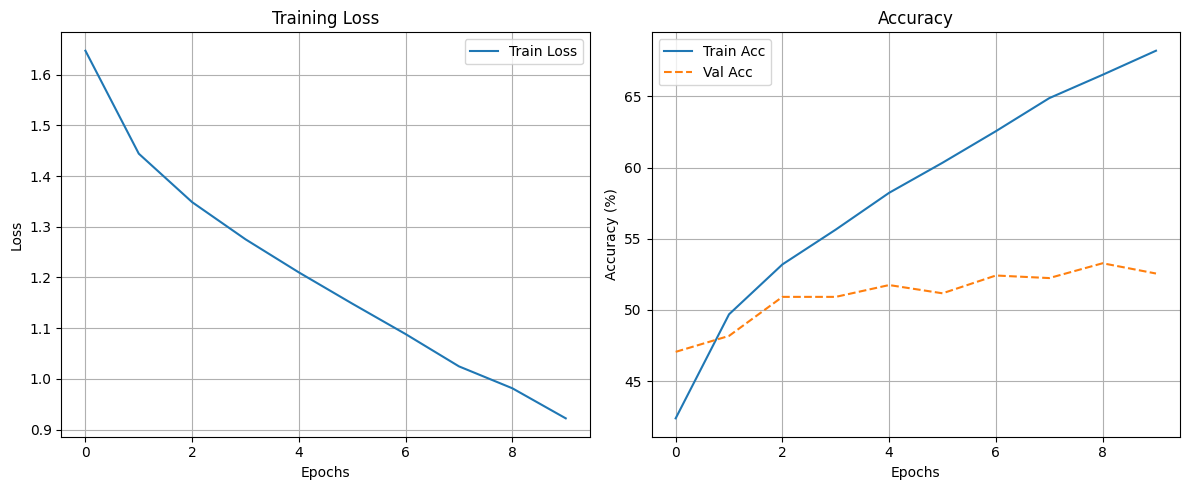

In [ ]:
# 학습 결과 시각화
plot_history(history_2_layer)

## 3-Layer MLP

### 3-Layer MLP 모델 정의

In [ ]:
class MLP_3_layer(nn.Module):
    def __init__(self):
        super(MLP_3_layer, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512) # 입력층 (3072) -> 은닉층1 (512)
        self.fc2 = nn.Linear(512, 256)         # 은닉층1 (512) -> 은닉층2 (256)
        self.fc3 = nn.Linear(256, 10)          # 은닉층2 (256) -> 출력층 (10)
        self.relu = nn.ReLU()                  # 활성화 함수

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)    # 이미지를 1차원 벡터로 변환
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net_3_layer = MLP_3_layer().to(device)

print("\n--- 3-Layer MLP Model ---")
print(net_3_layer)


--- 3-Layer MLP Model ---
MLP_3_layer(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


### 모델 학습 (Training)


--- 3-Layer MLP Model ---

--- Training ---
Epoch  1 | Train Loss: 1.628 | Train Acc: 42.14% | Val Acc: 47.08%
Epoch  2 | Train Loss: 1.407 | Train Acc: 50.38% | Val Acc: 49.72%
Epoch  3 | Train Loss: 1.294 | Train Acc: 54.51% | Val Acc: 51.71%
Epoch  4 | Train Loss: 1.195 | Train Acc: 57.65% | Val Acc: 53.20%
Epoch  5 | Train Loss: 1.110 | Train Acc: 60.94% | Val Acc: 53.41%
Epoch  6 | Train Loss: 1.029 | Train Acc: 63.42% | Val Acc: 54.10%
Epoch  7 | Train Loss: 0.954 | Train Acc: 66.15% | Val Acc: 54.04%
Epoch  8 | Train Loss: 0.876 | Train Acc: 68.68% | Val Acc: 53.90%
Epoch  9 | Train Loss: 0.803 | Train Acc: 71.64% | Val Acc: 53.87%
Epoch 10 | Train Loss: 0.726 | Train Acc: 74.23% | Val Acc: 53.81%
Finished Training.


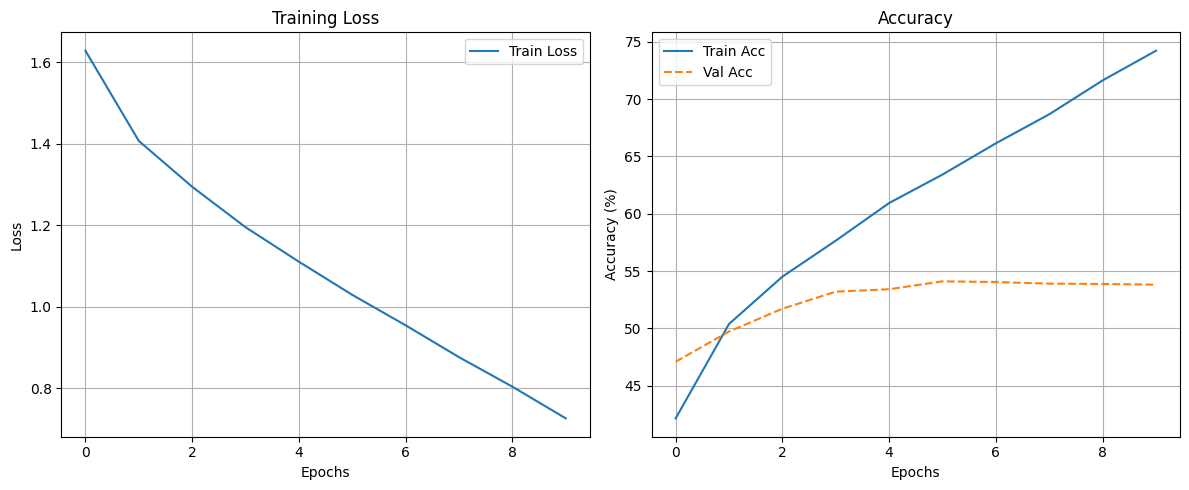

In [ ]:
print("\n--- 3-Layer MLP Model ---")
num_epoch = 10
history_3_layer = train_and_evaluate(net_3_layer, num_epoch)

# 학습 결과 시각화
plot_history(history_3_layer)

## 5-Layer MLP

In [ ]:
class MLP_5_layer(nn.Module):
    def __init__(self):
        super(MLP_5_layer, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512) # 입력층 (3072) -> 은닉층1 (512)
        self.fc2 = nn.Linear(512, 256)         # 은닉층1 (512) -> 은닉층2 (256)
        self.fc3 = nn.Linear(256, 256)         # 은닉층2 (256) -> 은닉층3 (256)
        self.fc4 = nn.Linear(256, 256)         # 은닉층3 (256) -> 은닉층4 (256)
        self.fc5 = nn.Linear(256, 10)          # 은닉층4 (256) -> 출력층 (10)
        self.relu = nn.ReLU()                  # 활성화 함수

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)    # 이미지를 1차원 벡터로 변환
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
net_5_layer = MLP_5_layer().to(device)

print("\n--- 5-Layer MLP Model ---")
print(net_5_layer)


--- 5-Layer MLP Model ---
MLP_5_layer(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)



--- 5-Layer MLP Model ---

--- Training ---
Epoch  1 | Train Loss: 1.687 | Train Acc: 39.60% | Val Acc: 45.38%
Epoch  2 | Train Loss: 1.447 | Train Acc: 48.56% | Val Acc: 50.17%
Epoch  3 | Train Loss: 1.323 | Train Acc: 53.21% | Val Acc: 51.54%
Epoch  4 | Train Loss: 1.221 | Train Acc: 57.00% | Val Acc: 53.25%
Epoch  5 | Train Loss: 1.134 | Train Acc: 59.83% | Val Acc: 51.82%
Epoch  6 | Train Loss: 1.053 | Train Acc: 62.30% | Val Acc: 53.86%
Epoch  7 | Train Loss: 0.971 | Train Acc: 65.25% | Val Acc: 53.79%
Epoch  8 | Train Loss: 0.897 | Train Acc: 67.95% | Val Acc: 55.21%
Epoch  9 | Train Loss: 0.821 | Train Acc: 70.59% | Val Acc: 54.21%
Epoch 10 | Train Loss: 0.761 | Train Acc: 72.43% | Val Acc: 54.34%
Finished Training.


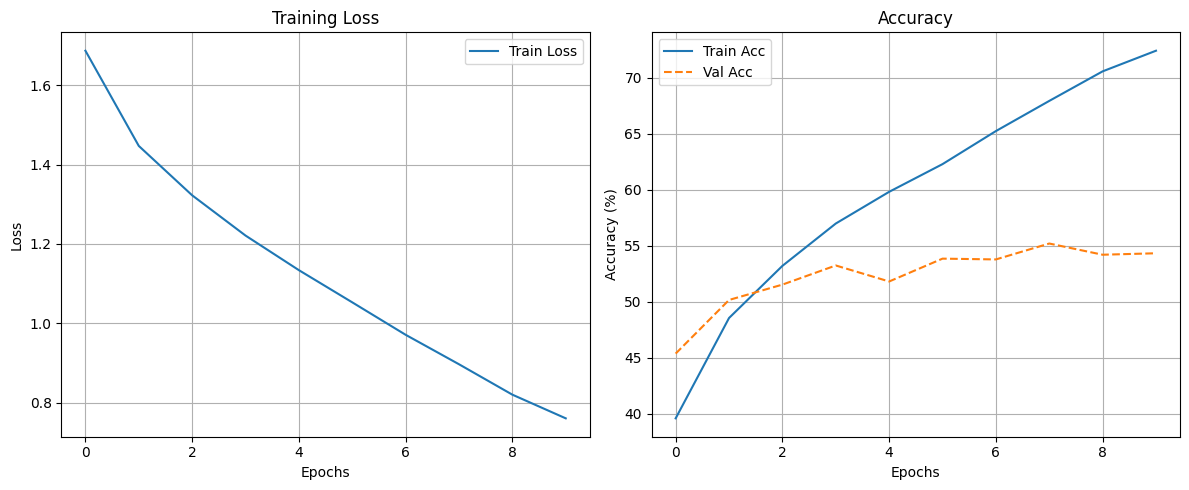

In [ ]:
print("\n--- 5-Layer MLP Model ---")
num_epoch = 10
history_5_layer = train_and_evaluate(net_5_layer, num_epoch)

# 학습 결과 시각화
plot_history(history_5_layer)